# Exercises week 5 part 1: Convolutions

IN5400 / IN9400 - Machine Learning for Image Analysis

---

### Task1: Convolution by hand

You are given an input image (x), kernel (w) and bias (b). Your task is to evaluate the shaded pixel in the image after the convolution. The origin of the kernel is the shaded pixel. Use zero padding and do not rotate the kernel (so the value you compute is technically the cross-correlation result at this pixel location).

<img src="images/x_w_b.png" alt="Drawing" style="width: 600px;"/>

<b>Solution:</b>
$$
\begin{aligned}
 z &= -9\cdot2 + 7\cdot5  \\
   &+ 4\cdot0 + 9\cdot2 \\
   &+ 1\cdot5 + 6\cdot1 \\
   &+ 2 \\
   &= 48
\end{aligned}
$$

---

### Task2: Implement function for convolution

You shall implement a general function that convolves an image of $M$x$N$ pixels and $C$ channels ($C=3$ for an RGB image) with a filter kernel of size $M_k$x$N_k$. Apply the filter independently to all $C$ channels of the image.

To compute the convolution result at location $[i,j,c]$, centre the filter kernel at location $[i,j,c]$ and multiply channel $c$ of the image and the filter at all locations where the filter overlaps with the image, and then sum the products. You shall first use 2 for-loops to compute this sum, and then use NumPy to compute it.

To compute the convolution result of all pixels, you need to loop over all the pixel positions and channels, in this case three for loops over image height $M$, width $N$ and channels $C$.

In this example, you shall compute the convolution only at those pixels where the filter kernel fits inside the image.

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import imageio
import time

plt.rcParams['figure.figsize'] = (14.0, 12.0)

In [2]:
def convolution_loops(image, kernel):
  """
  Convolves a MxNxC image with a MkxNk kernel.
  """
  out = np.zeros(image.shape)
  
  kernel = np.rot90(kernel, 2) # rotate 180 degrees to perform convolution (not correlation)
  
  M, N, C = image.shape
  Mk, Nk = kernel.shape
  mk_2 = Mk // 2
  nk_2 = Nk // 2
  for i in range(mk_2, M - Mk + mk_2 + 1):
    for j in range(nk_2, N - Nk + nk_2 + 1):
      for c in range(C):
        currsum = 0.0;
        for k in range(Mk):
          for l in range(Nk):
            currsum = currsum + image[i+k-mk_2,j+l-nk_2,c]*kernel[k,l]
        out[i, j, c] = currsum
  
  return out

You shall now implement a function that performs the same convolution, but instead of looping over the filter kernel, it should use either np.sum or np.dot. In the latter case, you should reshape the current subwindow and the filter into 1D vectors of length $N_k \cdot M_k$ before using np.dot.

In [3]:
def convolution(image, kernel):
  """
  Convolves a MxNxC image with a MkxNk kernel.
  """
  out = np.zeros(image.shape)
  
  kernel = np.rot90(kernel, 2) # rotate 180 degrees to perform convolution (not correlation)
  
  M, N, C = image.shape
  Mk, Nk = kernel.shape
  mk_2 = Mk // 2
  nk_2 = Nk // 2
  for i in range(mk_2, M - Mk + mk_2 + 1):
    for j in range(nk_2, N - Nk + nk_2 + 1):
      for c in range(C):
        out[i, j, c] = np.sum(image[i-mk_2:i+(Mk-mk_2),j-nk_2:j+(Nk-nk_2),c]*kernel)
  
  return out

In [4]:
# Check that your implementations provide the same result for a small 2D image.
f1 = np.arange(4)
f2 = np.arange(5)
f = f1[:, np.newaxis, np.newaxis] + f2[np.newaxis, :, np.newaxis]
print(f[:,:,0])
print(f.shape)

h = np.arange(9).reshape(3, 3)
print(h)
print(h.shape)

out1 = convolution_loops(f, h)
print(out1[:,:,0])

out2 = convolution(f, h)
print(out2[:,:,0])

[[0 1 2 3 4]
 [1 2 3 4 5]
 [2 3 4 5 6]
 [3 4 5 6 7]]
(4, 5, 1)
[[0 1 2]
 [3 4 5]
 [6 7 8]]
(3, 3)
[[  0.   0.   0.   0.   0.]
 [  0.  48.  84. 120.   0.]
 [  0.  84. 120. 156.   0.]
 [  0.   0.   0.   0.   0.]]
[[  0.   0.   0.   0.   0.]
 [  0.  48.  84. 120.   0.]
 [  0.  84. 120. 156.   0.]
 [  0.   0.   0.   0.   0.]]


Calculation time with inner loops: 12.57486367225647 sec
Calculation time without inner loops: 10.169786214828491 sec


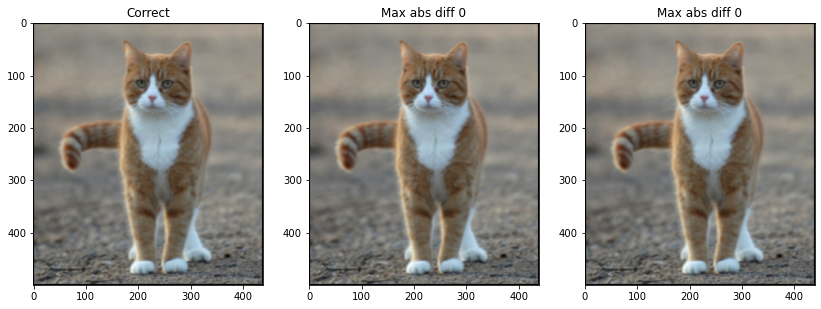

In [5]:
# Check that your implementations filter an image correctly.
img = imageio.imread('images/cat.png').astype(np.float64)

kernel = np.arange(25).reshape((5, 5))

start = time.time()
out1 = convolution_loops(img, kernel)
print('Calculation time with inner loops:', time.time()-start, 'sec')

start= time.time()
out2 = convolution(img, kernel)
print('Calculation time without inner loops:', time.time()-start, 'sec')

out1 -= out1.min()
out1 /= out1.max()
out1 *= 255
out1 = out1.astype(np.uint8)

out2 -= out2.min()
out2 /= out2.max()
out2 *= 255
out2 = out2.astype(np.uint8)

correct = imageio.imread('images/convolution_cat.png')
plt.figure()
plt.subplot(1, 3, 1)
plt.imshow(correct)
plt.title('Correct')
plt.subplot(1, 3, 2)
plt.imshow(out1)
plt.title('Max abs diff {}'.format(np.max(np.abs(correct-out1))))
plt.subplot(1, 3, 3)
plt.imshow(out2)
plt.title('Max abs diff {}'.format(np.max(np.abs(correct-out2))))
plt.show()

---

### Task3: Implement blurring function

You shall implement a function that use your convolution function to filter an image with an average filter (box filter) with kernel size of 11. The filter should have coefficients 1/(k_size*k_size)

In [6]:
def blur_filter(img):
  """
  Blurs a MxNxC image with an average filter (box filter) with kernel size of 11.
  """
  k_size = 11
  kernel = np.ones((k_size, k_size))/k_size**2
  return convolution(img, kernel)

Calculation time: 11.422206401824951 sec


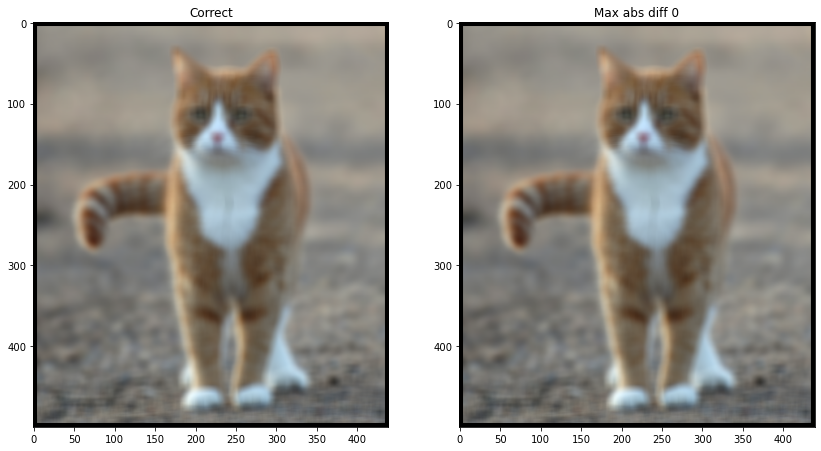

In [7]:
# Check that your blurring implementation is correct.
img = imageio.imread('images/cat.png').astype(np.float64)

start = time.time()
out = blur_filter(img)
print('Calculation time:', time.time()-start, 'sec')

out -= out.min()
out /= out.max()
out *= 255
out = out.astype(np.uint8)

correct = imageio.imread('images/blur_cat.png')
plt.figure()
plt.subplot(1, 2, 1)
plt.imshow(correct)
plt.title('Correct')
plt.subplot(1, 2, 2)
plt.imshow(out)
plt.title('Max abs diff {}'.format(np.max(np.abs(correct-out))))
plt.show()

---

### Task4: Implement gradient magnitude function

You shall implement a function that use your convolution function to filter an image with each Sobel kernel and then computes the gradient magnitude image. If the input image has multiple channels, then compute the gradient magnitude of each channel and take the maximum at each pixel location.

In [8]:
def gradient_magnitude(img):
  """
  Computes the gradient magnitude of a MxNxC image using the Sobel kernels.
  """
  sobel_y = np.array([[1, 2, 1],
                      [0, 0, 0],
                      [-1, -2, -1]])
  sobel_x = np.array([[1, 0, -1 ],
                      [2, 0, -2],
                      [1, 0, -1]])
  dy = convolution(img, sobel_y)
  dx = convolution(img, sobel_x)
  return np.max(np.sqrt(dy**2+dx**2), axis=2)

Calculation time: 21.93661379814148 sec


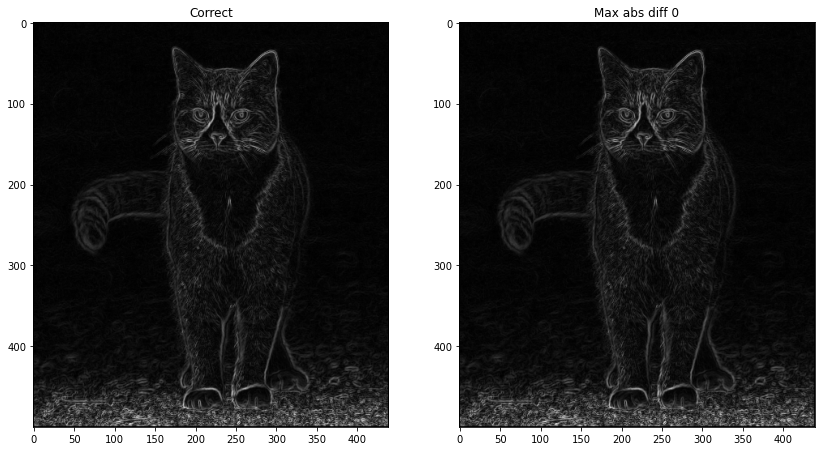

In [9]:
# Check that your gradient magnitude implementation is correct.
img = imageio.imread('images/cat.png').astype(np.float64)

start = time.time()
out = gradient_magnitude(img)
print('Calculation time:', time.time()-start, 'sec')

out -= out.min()
out /= out.max()
out *= 255
out = out.astype(np.uint8)

correct = imageio.imread('images/sobel_cat.png')
plt.figure()
plt.subplot(1, 2, 1)
plt.imshow(correct, cmap='gray')
plt.title('Correct')
plt.subplot(1, 2, 2)
plt.imshow(out, cmap='gray')
plt.title('Max abs diff {}'.format(np.max(np.abs(correct-out))))
plt.show()

---

### Task5: Implement gradient magnitude function using PyTorch

You shall now implement a function that performs the same gradient magnitude computation, but instead of using your convolution function, it should use \"F.conv2d\" (\"torch.nn.functional\" is imported as \"F\").

The formats of the inputs to \"F.conv2d\" are designed to be suitable for use in convolutional neural networks (although we would often call \"torch.nn.Conv2d\" in a \"torch.nn.Module\" class). The function therefore by default expects filters with a number of channel equal to the number of channels in the input image. To obtain a convolution result per channel of the input image, you should implement depthwise convolution, which you could do by specifying the "group" option of \"F.conv2d\" to the number of channels. Since we should be convolving all channels with the same filters, the Sobel kernels are in the code below repeated along the channel dimension to match the number of channels in the input image.

By default \"F.conv2d\" does not pad and only computes the convolution result at pixels where the filter kernels fit inside the image. Do not change this default behaviour. The code below will zero-pad your convolution result with 1 pixel on both sides, which will make its output directly comparable to the output of your convolution function. (If instead using \"F.conv2d\" to pad, then we will get some non-zero values at the border of the convolution result, which makes sense in general, but you should not do it here because you were not asked to do it in your Python/NumPy convolution function.)

In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F

def gradient_magnitude_torch(img):
  """
  Computes the gradient magnitude of a MxNxC image using the Sobel kernels.
  """
  device = torch.device('cpu')
  channels = img.shape[2]
  img_torch = torch.as_tensor(img, device=device).permute(2,0,1).unsqueeze(0)
  sobel_y = torch.as_tensor([[1, 2, 1],
                             [0, 0, 0],
                            [-1, -2, -1]], dtype=torch.float64)
  sobel_y = torch.rot90(sobel_y, 2).unsqueeze(0).unsqueeze(0).repeat(channels, 1, 1, 1)
  sobel_x = torch.as_tensor([[1, 0, -1 ],
                             [2, 0, -2],
                             [1, 0, -1]], dtype=torch.float64)
  sobel_x = torch.rot90(sobel_x, 2).unsqueeze(0).unsqueeze(0).repeat(channels, 1, 1, 1)
  dy = F.conv2d(img_torch, sobel_y, groups=channels)
  dx = F.conv2d(img_torch, sobel_x, groups=channels)
  img_torch = torch.max(torch.sqrt(dy**2+dx**2), dim=1)[0]
  m = nn.ZeroPad2d(1)
  return m(img_torch.squeeze()).cpu().data.numpy()

Calculation time: 0.0528717041015625 sec


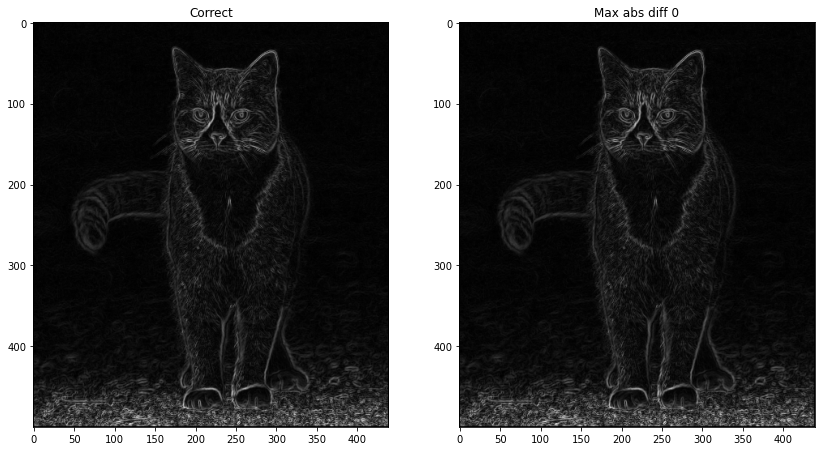

In [11]:
# Check that your gradient magnitude implementation is correct.
img = imageio.imread('images/cat.png').astype(np.float64)

start = time.time()
out = gradient_magnitude_torch(img)
print('Calculation time:', time.time()-start, 'sec')

out -= out.min()
out /= out.max()
out *= 255
out = out.astype(np.uint8)

correct = imageio.imread('images/sobel_cat.png')
plt.figure()
plt.subplot(1, 2, 1)
plt.imshow(correct, cmap='gray')
plt.title('Correct')
plt.subplot(1, 2, 2)
plt.imshow(out, cmap='gray')
plt.title('Max abs diff {}'.format(np.max(np.abs(correct-out))))
plt.show()